In [ ]:
# input event

# load event details

# determine radius

# cross reference with available 5Hz

# make station list

# determine start time/end time

# run processing

# plot results


In [1]:
import sys
import os
import datetime
import urllib.request
import csv
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

import json




In [2]:
def calculate_p_s_arrival(station, eq):
    
    """
    Function calculates arrival times for P and S waves
    
    Parameters
    ----------
    :param station: gtsm_station class object
        Must include the following attributes
        :station.lat: float
        :station.long: float
    :param eq: earthquake class object
        Must include the following attributes
        :eq.lat: float
        :eq.long: float
        :eq.time: datetime.datetime
    :return:
        Adds attributes to station object
        :station.p_delta: datetime.timedelta 
        :station.s_delta: datetime.timedelta
        :station.p_arrival: datetime.datetime
        :station.s_arrival: datetime.datetime
    """
    
    event_loc="["+str(eq.lat)+","+str(eq.long)+"]"
    station_loc="["+str(station.lat)+","+str(station.long)+"]"
    url = "https://service.iris.edu/irisws/traveltime/1/query?evloc="+event_loc+"&staloc="+station_loc
    df=pd.read_table(url, sep="\s+", header=1, index_col=2, usecols=[2,3])
    
    station.p_delta = datetime.timedelta(seconds=float(df.iloc[(df.index == 'P').argmax()].Travel))
    station.s_delta = datetime.timedelta(seconds=float(df.iloc[(df.index == 'S').argmax()].Travel))
    station.p_arrival = eq.time + station.p_delta
    station.s_arrival = eq.time + station.s_delta
    return station

class gnss_station:
    """
    Class object containing data and metadata for a gnss station
    """
    
    def __init__(self, fourchar):
        self.name = fourchar

    
class earthquake:
    """
    Class object containing parameters for a specific earthquake event
    """
    
    def __init__(self, eventID):
        self.eventID = eventID

        
def load_event_data(eventID):
    """
    Function loads earthquake parameters for a given event into an earthquake object
       
    Parameters
    ----------
    :param eventID: str
    :return: eq: earthquake class object   
    """
    
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&eventid="+eventID
    response = urllib.request.urlopen(url)
    data = json.loads(response.read())

    #define earthquake class object
    eq = earthquake(eventID)
    eq.eventID
    eq.name = data["properties"]['title']
    eq.mag = data["properties"]['mag']
    eq.unix_time = data['properties']['time']
    print(eq.unix_time)
    eq.time = datetime.datetime.fromtimestamp(eq.unix_time/1000.0)
    eq.time= pd.to_datetime(eq.unix_time, unit='ms')
    print(eq.time)
    eq.lat = data["geometry"]['coordinates'][1]
    eq.long = data["geometry"]['coordinates'][0]
    eq.depth = data["geometry"]['coordinates'][2]
    
    #write_event_coords(eq)
    return eq

#Get distance between pairs of lat-lon points

def distance(
        ep,
        depth,
        gps):
    """
    distance calculates the hypocentral distances between a station and the epicenter

    Parameters
    ----------
    ep is the lat, long of the event
    depth is the depth of the event (km)
    gps is the lat, long of the station

    :return:
       hypocentral distance in km
    """
    dist =  geopy.distance.geodesic( ep,gps ).km
    hypo = np.sqrt(np.power(dist, 2) + np.power(depth, 2) )
    return hypo

def pgv_radius(
        mag, 
        disp
        ):
    """
    Calculates cutoff distance for  dynamic strains

    Paramters:
    ----------
    mag = magnitude
    disp = displacement in meters/sec

    Returns:
    dist = cutoff distance  in km

    """
    # Fang et al. (2020) coefficients
    A=-5.025 
    B=0.741
    C=-0.111 

    log10_R = ( np.log10(disp) -1*A  - B * mag )/(C* mag)
    dist    = np.power(10,log10_R )
        
    return dist

def calc_distance(from_loc, to_lat, to_long):
    return geopy.distance.geodesic(from_loc, (to_lat, to_long)).km


def get_5hz_list(year,doy):
    from ftplib import FTP 
  
    ftp = FTP('data-out.unavco.org') 

    ftp.login() 

    # changing directory 
    d='/pub/highrate/5-Hz/rinex/%s/%s' %(year,doy)
    ftp.cwd(d) 

    #files = []
    count_list=[]
    f=ftp.nlst()

    ftp.quit()
    return f


def read_vel(station,year,doy):
    '''
    array is array from li_df dataframe
    '''
    
    #fname='output/%s/velocities_%s_%03d_%s.txt' %(event,station,doy,year)
    fname='SNIVEL/output/velocities_%s_%s_%s.txt' %(station,doy,year)
    fpath=os.path.join(os.path.dirname(os.getcwd()), fname)
    vel_df=pd.read_csv(fpath, header=None, sep=' ', usecols=[1,2,3,4,5], names=['gpst','dndt','dedt','dudt','clk'])
    utc_diff=gps_2_utc(vel_df.gpst[0])
    print(utc_diff)
    vel_df['utc'] = vel_df.gpst + utc_diff 
    vel_df.index=(pd.to_datetime(vel_df.utc, unit='s', origin='unix'))
    return vel_df

def gps_2_utc(gpstime):
    '''
    calculates offset between gps time and utc (unix) time
    '''
    # Convert GPS time to UTC and index
    gps = datetime.datetime(1980,1,6)
    utc = datetime.datetime(1970,1,1)
    diff=gps-utc
    #https://en.racelogic.support/VBOX_Automotive/01General_Information/Knowledge_Base/What_are_GPS_Leap_Seconds%3F
    leap_sec=gpsleapsec(gpstime)
    utc_diff=diff.seconds + diff.days * 86400 - leap_sec #total seconds including leap seconds
    return utc_diff
    #CREATE FUNCTION FOR LEAP SECONDS

def gpsleapsec(gpssec):
    '''
    number of leapseconds at given gps time epoch
    taken from B.Crowell's Snivel package
    '''
    leaptimes = np.array([46828800, 78364801, 109900802, 173059203, 252028804, 315187205, 346723206, 393984007, 425520008, 457056009, 504489610, 551750411, 599184012, 820108813, 914803214, 1025136015, 1119744016, 1167264017])
    leapseconds = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    a1 = np.where(gpssec > leaptimes)[0]
    leapsec = len(a1)
    return(leapsec)

def calculate_p_s_arrival(station, eq):
    
    """
    Function calculates arrival times for P and S waves
    
    Parameters
    ----------
    :param station: gtsm_station class object
        Must include the following attributes
        :station.lat: float
        :station.long: float
    :param eq: earthquake class object
        Must include the following attributes
        :eq.lat: float
        :eq.long: float
        :eq.time: datetime.datetime
    :return:
        Adds attributes to station object
        :station.p_delta: datetime.timedelta 
        :station.s_delta: datetime.timedelta
        :station.p_arrival: datetime.datetime
        :station.s_arrival: datetime.datetime
    """
    
    event_loc="["+str(eq.lat)+","+str(eq.long)+"]"
    station_loc="["+str(station.lat)+","+str(station.long)+"]"
    url = "https://service.iris.edu/irisws/traveltime/1/query?evloc="+event_loc+"&staloc="+station_loc
    df=pd.read_table(url, sep="\s+", header=1, index_col=2, usecols=[2,3])
    
    station.p_delta = datetime.timedelta(seconds=float(df.iloc[(df.index == 'P').argmax()].Travel))
    station.s_delta = datetime.timedelta(seconds=float(df.iloc[(df.index == 'S').argmax()].Travel))
    station.p_arrival = eq.time + station.p_delta
    station.s_arrival = eq.time + station.s_delta
    return station

In [3]:
# load event
eventID='us6000hf75'
eventID='nc73666231'
#eventID='ci38457511'
eventID='usp000jrsw'
eq=load_event_data(eventID)

eq_doy=(eq.time-datetime.datetime(eq.time.year, 1, 1)).days + 1
eq_year=eq.time.year

1346856127800
2012-09-05 14:42:07.800000


In [4]:
# get a radius
#select threshold of sensativity
disp=0.02 #m/s, .01 is 25% of pgv thresholds from previous work
radius_=pgv_radius(eq.mag, disp)

In [5]:
# generate list of 5hz available that time
avail_list=get_5hz_list(eq_year,eq_doy)

In [6]:
# station coordinates dataframe -- must be a cleaner way to do this, but this works

import requests
from io import StringIO

url='https://web-services.unavco.org/gps/metadata/sites/v1?minlatitude=-180&maxlatitude=180&minlongitude=-180&maxlongitude=180&starttime=&endtime=&summary=false'
req = requests.get(url)
data = StringIO(req.text)

sta_coords_df = pd.read_csv(data)

sta_coords_df=sta_coords_df.drop_duplicates(subset=sta_coords_df.columns[0])[[sta_coords_df.columns[0],sta_coords_df.columns[2],sta_coords_df.columns[3]]]
sta_coords_df.rename(columns={sta_coords_df.columns[0]:'stations'}, inplace=True)
sta_coords_df["stations"]=sta_coords_df.stations.str.lower()
#sta_coords_df=pd.read_csv(url)

In [7]:
sta_coords_df=sta_coords_df[sta_coords_df['stations'].isin(avail_list)]

In [8]:
#calculate radius from station to  event
epicenter = (eq.lat, eq.long)
sta_coords_df['HypocentralDistance']   = sta_coords_df.apply(lambda row: distance(  epicenter , eq.depth, (row.latitude,row.longitude )),  axis=1 )

In [9]:
sta_used=sta_coords_df[sta_coords_df.HypocentralDistance<radius_]
#limit to closest 5?
sta_used=sta_used.sort_values(by=['HypocentralDistance']).head(3)

In [11]:
eq.lat

10.085

In [12]:
eq.long

-85.315

In [10]:
sta_used


,stations,latitude,longitude,HypocentralDistance
15661,puje,10.1140,-85.2725,35.454030
15583,caba,10.2379,-85.3435,38.997090
9264,qsec,9.8404,-85.3573,44.479938


In [294]:
#filter by radius and write to stations file

MyList = sta_used.stations.values.tolist()
MyFile=open('sites_process.txt','w')

for element in MyList:
     MyFile.write(element)
     MyFile.write('\n')
MyFile.close()

In [296]:
#dates file
t_string=(pd.to_datetime(eq.time)-datetime.timedelta(minutes=0.5)).strftime('%X')
duration=1.5
#2019 187 03:19:00 5
text_file = open("dates_process.txt", "w")
n = text_file.write('%s %s %s %s' %(eq_year,eq_doy,t_string,duration))
text_file.close()

In [297]:
!python SNIVEL_mp.py

--2022-04-27 20:34:29--  ftps://gdc.cddis.eosdis.nasa.gov/gnss/data/daily/2012/249/12n/brdc2490.12n.Z
           => ‘nav/brdc2490.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gnss/data/daily/2012/249/12n ... done.
==> SIZE brdc2490.12n.Z ... 66023
==> PASV ... done.    ==> RETR brdc2490.12n.Z ... done.
Length: 66023 (64K) (unauthoritative)
Resuming SSL session in data connection.

brdc2490.12n.Z      100%[===================>]  64.48K   265KB/s    in 0.2s    

2022-04-27 20:34:31 (265 KB/s) - ‘nav/brdc2490.12n.Z’ saved [66023]

There are 8 CPUs on this machine 
Processing station  puje  on year and  day  2012 249
Attempting to download rinex_hr/puje2490.12d from UNA

315964784


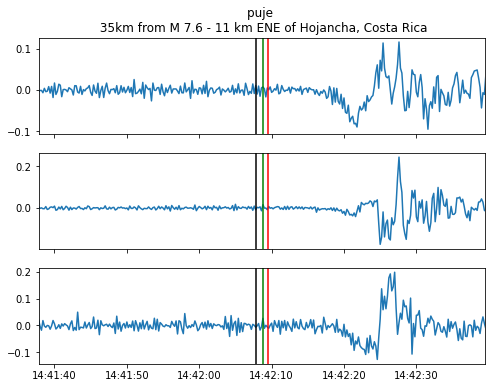

315964784


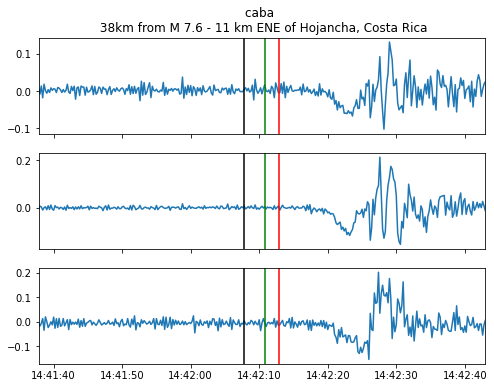

315964784


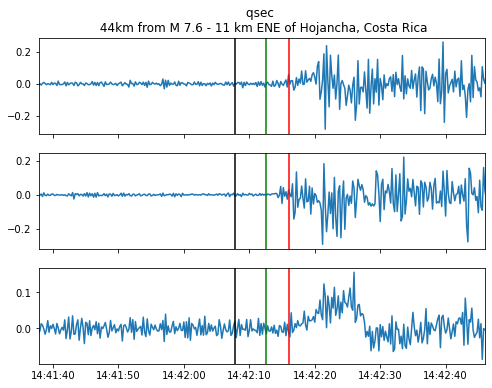

In [311]:
for site in MyList:
    #site='p158'
    try:
        vel_df=read_vel(site,eq_year,eq_doy)

        station = gnss_station(site)
        station.lat=sta_coords_df[sta_coords_df.stations==site].latitude.values[0]
        station.long=sta_coords_df[sta_coords_df.stations==site].longitude.values[0]

        station=calculate_p_s_arrival(station, eq)
        fig, ax = plt.subplots(3, 1, figsize=(8,6), sharex=True)

        for i,direc in enumerate(['dedt','dndt','dudt']):
            ax[i].plot(vel_df[direc])
            #plt.axvline(pd.to_datetime('2021-11-09 06:25:17'))
            ax[i].axvline(eq.time, color='black')
            ax[i].axvline(station.s_arrival, color='red')
            ax[i].axvline(station.p_arrival, color='green')
        hypo_radius=sta_used[sta_used.stations==site].HypocentralDistance.values[0]
        ax[0].set_title('%s \n %02dkm from %s' %(site, hypo_radius, eq.name))
        ax[i].set_xlim([eq.time-datetime.timedelta(minutes=0.5), station.s_arrival+datetime.timedelta(minutes=.5)])
        plt.show()
    except:
        pass